In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D
from keras.optimizers import Adam, SGD

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import Callback
import random


Using TensorFlow backend.


In [2]:
ENV_NAME = 'LunarLander-v2'

env = gym.make(ENV_NAME)

[2017-01-10 22:31:02,491] Making new env: LunarLander-v2


In [3]:
nb_actions = env.action_space.n
nb_frames = 4
height = 100
width = 100

HIDDEN_SIZE = 256
LEARNING_RATE = LEARNING_RATE = 0.000001
MEMORY_SIZE = 200  # CHANGE TO BIGGER VALUE BEFORE RUNNING
BATCH_SIZE = 32  # CHANGE TO BIGGER VALUE BEFORE RUNNING
GAMMA = 0.95
TAU = 0.001

model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
#print(model.summary())


model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(HIDDEN_SIZE, activation='relu'))
model.add(Dense(nb_actions))
sgd = SGD(lr=LEARNING_RATE)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_2 (Flatten)              (None, 8)             0           flatten_input_2[0][0]            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 40)            360         flatten_2[0][0]                  
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 40)            0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 40)            1640        activation_4[0][0]               
___________________________________________________________________________________________

In [4]:
memory = SequentialMemory(limit=500000, window_length=1)
policy = EpsGreedyQPolicy(eps=1.0)

In [5]:
class EpsDecayCallback(Callback):
    def __init__(self, eps_poilcy, decay_rate=0.95):
        self.eps_poilcy = eps_poilcy
        self.decay_rate = decay_rate
    def on_episode_begin(self, episode, logs={}):
        self.eps_poilcy.eps *= self.decay_rate
        print('eps = %s' % self.eps_poilcy.eps)

In [6]:
class LivePlotCallback(Callback):
    def __init__(self, nb_episodes=4000, avgwindow=20):
        self.rewards = np.zeros(nb_episodes) - 1000.0
        self.X = np.arange(1, nb_episodes+1)
        self.avgrewards = np.zeros(nb_episodes) - 1000.0
        self.avgwindow = avgwindow
        self.rewardbuf = []
        self.episode = 0
        self.nb_episodes = nb_episodes
        plt.ion()
        self.fig = plt.figure()
        self.grphinst = plt.plot(self.X, self.rewards, color='b')[0]
        self.grphavg  = plt.plot(self.X, self.avgrewards, color='r')[0]
        plt.ylim([-450.0, 350.0])
        plt.xlabel('Episodes')
        plt.legend([self.grphinst, self.grphavg], ['Episode rewards', '20-episode-average-rewards'])
        plt.grid(b=True, which='major', color='k', linestyle='-')
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='k', linestyle='--')

    def __del__(self):
        self.fig.savefig('monitor/plot.png')
        
    def on_episode_end(self, episode, logs):
        if self.episode >= self.nb_episodes:
            return
        rw = logs['episode_reward']
        self.rewardbuf.append(rw)
        if len(self.rewardbuf) > self.avgwindow:
            del self.rewardbuf[0]
        self.rewards[self.episode] = rw
        self.avgrewards[self.episode] = np.mean(self.rewardbuf)
        self.plot()
        self.episode += 1
    def plot(self):
        self.grphinst.set_ydata(self.rewards)
        self.grphavg.set_ydata(self.avgrewards)
        plt.draw()
        plt.pause(0.01)

In [7]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy, enable_double_dqn=False)
#dqn.compile(Adam(lr=0.002, decay=2.25e-05), metrics=['mse'])
dqn.compile(sgd, metrics=['mse'])

Training for 1000 steps ...
eps = 0.975


/Users/ilyes/anaconda/lib/python3.5/site-packages/keras_rl-0.2.0rc1-py3.5.egg/rl/memory.py:29: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


  84/1000: episode: 1, duration: 3.326s, episode steps: 84, steps per second: 25, episode reward: -205.191, mean reward: -2.443 [-100.000, 9.072], mean action: 1.560 [0.000, 3.000], mean observation: -0.082 [-1.431, 1.000], loss: 1.704885, mean_squared_error: 0.854462, mean_q: 0.097887
eps = 0.9506249999999999
 177/1000: episode: 2, duration: 1.308s, episode steps: 93, steps per second: 71, episode reward: -160.474, mean reward: -1.726 [-100.000, 6.415], mean action: 1.473 [0.000, 3.000], mean observation: -0.101 [-5.654, 1.000], loss: 52.461761, mean_squared_error: 26.233131, mean_q: 0.095220
eps = 0.9268593749999999
 313/1000: episode: 3, duration: 1.823s, episode steps: 136, steps per second: 75, episode reward: -93.359, mean reward: -0.686 [-100.000, 52.981], mean action: 1.485 [0.000, 3.000], mean observation: 0.173 [-1.588, 2.070], loss: 40.263840, mean_squared_error: 20.133696, mean_q: 0.075567
eps = 0.9036878906249999
 405/1000: episode: 4, duration: 1.243s, episode steps: 92, 

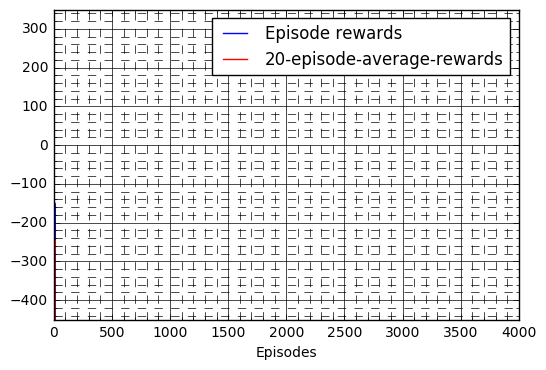

In [8]:
cbs = [EpsDecayCallback(eps_poilcy=policy, decay_rate=0.975)]
cbs += [LivePlotCallback(nb_episodes=4000, avgwindow=20)]
dqn.fit(env, nb_steps=1000, visualize=False, verbose=2, callbacks=cbs)

In [9]:
# evaluate the algorithm for 100 episodes.
dqn.test(env, nb_episodes=100, visualize=True)

Testing for 100 episodes ...
Episode 1: reward: -307.101, steps: 69
Episode 2: reward: -332.473, steps: 105
Episode 3: reward: -406.065, steps: 100
Episode 4: reward: -419.932, steps: 59
Episode 5: reward: -439.230, steps: 111
Episode 6: reward: -378.687, steps: 72
Episode 7: reward: -250.369, steps: 75
Episode 8: reward: -379.289, steps: 85
Episode 9: reward: -126.165, steps: 58
Episode 10: reward: -146.381, steps: 65
Episode 11: reward: -632.130, steps: 93
Episode 12: reward: -432.207, steps: 85
Episode 13: reward: -143.921, steps: 76
Episode 14: reward: -273.386, steps: 113
Episode 15: reward: -575.533, steps: 84
Episode 16: reward: -314.721, steps: 75
Episode 17: reward: -555.047, steps: 105
Episode 18: reward: -397.607, steps: 81
Episode 19: reward: -469.168, steps: 105
Episode 20: reward: -501.476, steps: 81
Episode 21: reward: -457.863, steps: 83
Episode 22: reward: -409.458, steps: 63
Episode 23: reward: -461.648, steps: 78
Episode 24: reward: -380.533, steps: 73
Episode 25: re

In [10]:
dqn.get_config()

{'batch_size': 32,
 'delta_clip': inf,
 'enable_double_dqn': False,
 'gamma': 0.99,
 'memory': {'class_name': 'SequentialMemory',
  'config': {'ignore_episode_boundaries': False,
   'limit': 500000,
   'window_length': 1}},
 'memory_interval': 1,
 'model': {'class_name': 'Sequential',
  'config': [{'class_name': 'Flatten',
    'config': {'batch_input_shape': (None, 1, 8),
     'input_dtype': 'float32',
     'name': 'flatten_2',
     'trainable': True}},
   {'class_name': 'Dense',
    'config': {'W_constraint': None,
     'W_regularizer': None,
     'activation': 'linear',
     'activity_regularizer': None,
     'b_constraint': None,
     'b_regularizer': None,
     'bias': True,
     'init': 'glorot_uniform',
     'input_dim': 8,
     'name': 'dense_4',
     'output_dim': 40,
     'trainable': True}},
   {'class_name': 'Activation',
    'config': {'activation': 'relu',
     'name': 'activation_4',
     'trainable': True}},
   {'class_name': 'Dense',
    'config': {'W_constraint': None,

In [ ]:
dqn.